In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(47907)
random.seed(15213)

In [4]:
'''
Generate scatter plot by similarity
Attributes:
    simi_mtxs : list of simi_mtxs or simi_col_mtxs using different number of features
    simi_data : should be same for all simi_mtxs
    feature_groups: labels of the feature group: top3, top7, plan, resource, all
    root_idx: the i-th experiment as the base run, will plot pairwise distance between the base run and other runs
    method_type: Type of method used to calculate similarity
    colwise: True if the calculation is columnwised, False if not
'''
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(4*len(feature_groups)/3, 4))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):       
        curr_zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    res3 = X_p[X_p['feature_group'] == 'res_3']
    res3 = res3.sort_values('distance', inplace=False)
    print(res3.head(8))

    print(X_p[X_p['feature_group'] == 'res_3'].shape)
    # X_p.drop([root_idx],inplace=True)

    sns.barplot(y="distance", x="feature_group", hue="workload", data=X_p, ax=ax, 
                    palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    if len(feature_groups) == 3:
        plt.legend(bbox_to_anchor=(-0.3, 1, 1.35, 0), loc='lower left', ncol=2, mode="expand")
    else:    
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=3, mode="expand")
    print(title)
    plt.savefig(f'figs/Twitter_{fname}', bbox_inches = 'tight')
    plt.show()

In [5]:
data = ExprData()
data.load_pickle()
data = data.remove_by_wlname(['ycsb', 'xml'])
data = data.fix_tpch()
data_by_sku = data.split_by_sku()

# use for later distinguish btw plan and system metrics
perf_features = data.perf_feature_cols
plan_features = data.plan_feature_cols
all_features = data.feature_cols

feature_group_all = ['plan_3', 'plan_7', 'plan', 'res_3', 'res_5', 'res', 'all_3', 'all_7', 'all']
feature_group_plan = ['plan_3', 'plan_7', 'plan']
feature_group_perf = ['res_3', 'res_5', 'res']

In [6]:
# the result sku_result is a dict with its key the SKU,
# the value a list, the classification accuracy for each f_num
simi_dict = {}

for sku in data_by_sku.keys():
    if 'ter' in sku or 'xml' in sku:
        continue
    curr_data = data_by_sku[sku]
    scaler = ScaleData()
    plan_mtxs, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

    simi_calc = Similarity(curr_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
    simi_calc.calc_bined_mtx() # all features
    simi_dict[sku] = simi_calc

### Comparing Feature Sets

In [7]:
# Pick one cpu setting (cpu=16 for example)
simi_calc = simi_dict['cpu16']

In [8]:
# Use top-k feature from all features
fs = FeatureSelection(simi_calc)

top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type=None)
top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)
plan_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='perf')
plan_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_7 = fs.select_features(5, 'fANOVA', est_name=None, direction=None, feature_type='perf')

features_all = [plan_top_3, plan_top_7, plan_features, perf_top_3, perf_top_7, perf_features, top_3, top_7, all_features]
features_plan = [plan_top_3, plan_top_7, plan_features]
features_perf = [perf_top_3, perf_top_7, perf_features]

(27, 27, 29)
(27, 27, 29)
(27, 27, 22)
(27, 27, 7)
(27, 27, 22)
(27, 27, 7)


In [9]:
perf_features

['CPU_UTILIZATION',
 'CPU_EFFECTIVE',
 'MEM_UTILIZATION',
 'IOPS_TOTAL',
 'READ_WRITE_RATIO',
 'LOCK_REQ_ABS',
 'LOCK_WAIT_ABS']

In [10]:
top_3

['AvgRowSize', 'StatementSubTreeCost', 'LOCK_WAIT_ABS']

In [11]:
top_7

['AvgRowSize',
 'StatementSubTreeCost',
 'LOCK_WAIT_ABS',
 'CachedPlanSize',
 'MEM_UTILIZATION',
 'MaxCompileMemory',
 'TableCardinality']

In [12]:
plan_top_3

['StatementSubTreeCost', 'AvgRowSize', 'CachedPlanSize']

In [13]:
plan_top_7

['StatementSubTreeCost',
 'AvgRowSize',
 'CachedPlanSize',
 'MaxCompileMemory',
 'CompileMemory',
 'TableCardinality',
 'EstimateIO']

In [14]:
perf_top_3

['LOCK_WAIT_ABS', 'MEM_UTILIZATION', 'LOCK_REQ_ABS']

In [15]:
perf_top_7

['LOCK_WAIT_ABS',
 'MEM_UTILIZATION',
 'LOCK_REQ_ABS',
 'CPU_UTILIZATION',
 'CPU_EFFECTIVE']

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def pred_stats(simi_calc, n=1, dependent=True, print_label=False):
    true_labels = simi_calc.data.wl_names
    pred_labels = simi_calc.simi_pred(n, dependent)
    if print_label:
        print(f'True labels: {true_labels}')
        print(f'Pred labels: {pred_labels}')
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    return acc, prec, f1, rec

### TS Norm

True labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
Pred labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
True labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter']
Pred labels: ['tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpcc', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'tpch', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twitter', 'twit

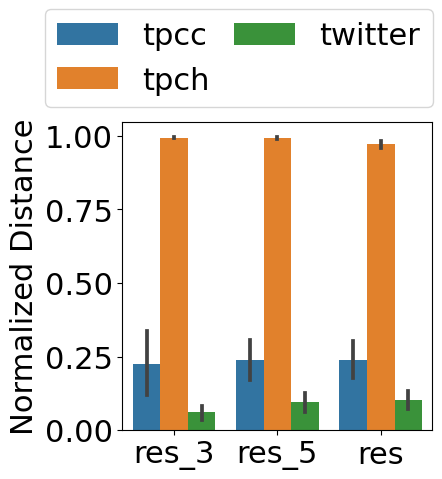

In [17]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
    result_stats = pred_stats(simi_calc, n=1, dependent=True, print_label=True)

plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS L21 Norm', colwise=True, note='')

   run workload feature_group  distance
18   3  twitter         res_3  0.002028
19   3  twitter         res_3  0.021469
8    8     tpcc         res_3  0.053255
6    8     tpcc         res_3  0.057305
7    8     tpcc         res_3  0.067451
21   4  twitter         res_3  0.079055
20   4  twitter         res_3  0.079348
22   4  twitter         res_3  0.079599
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.MTS L11 Norm


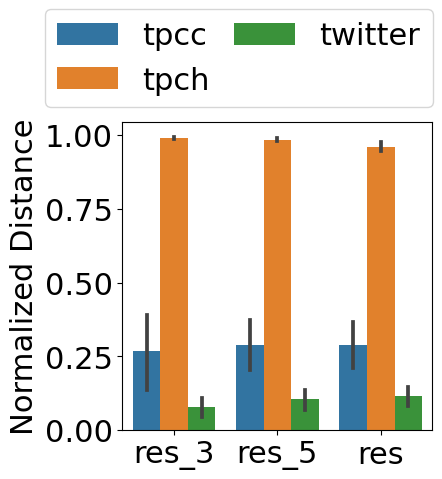

In [18]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS L11 Norm', colwise=True, note='')

   run workload feature_group  distance
18   3  twitter         res_3  0.002303
19   3  twitter         res_3  0.024968
8    8     tpcc         res_3  0.057007
6    8     tpcc         res_3  0.062103
7    8     tpcc         res_3  0.074094
21   4  twitter         res_3  0.091975
20   4  twitter         res_3  0.092316
22   4  twitter         res_3  0.092591
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.MTS Fro Norm


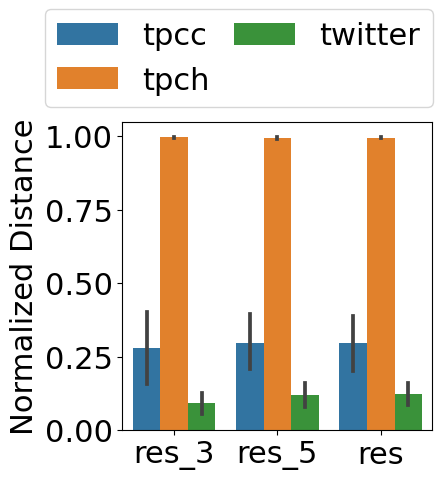

In [19]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Fro Norm', colwise=True, note='')

   run workload feature_group  distance
18   3  twitter         res_3  0.005342
19   3  twitter         res_3  0.042545
20   4  twitter         res_3  0.121477
21   4  twitter         res_3  0.131534
22   4  twitter         res_3  0.131952
23   9  twitter         res_3  0.184458
24   9  twitter         res_3  0.223860
25   9  twitter         res_3  0.231131
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.MTS Canb Norm


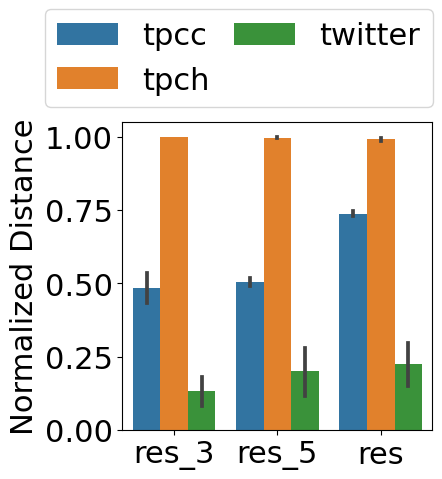

In [20]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Canb Norm', colwise=True, note='')

   run workload feature_group  distance
18   3  twitter         res_3  0.001319
19   3  twitter         res_3  0.002003
22   4  twitter         res_3  0.006639
23   9  twitter         res_3  0.009648
1    1     tpcc         res_3  0.536657
6    8     tpcc         res_3  0.541278
8    8     tpcc         res_3  0.544881
5    7     tpcc         res_3  0.545052
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.MTS Corr Norm


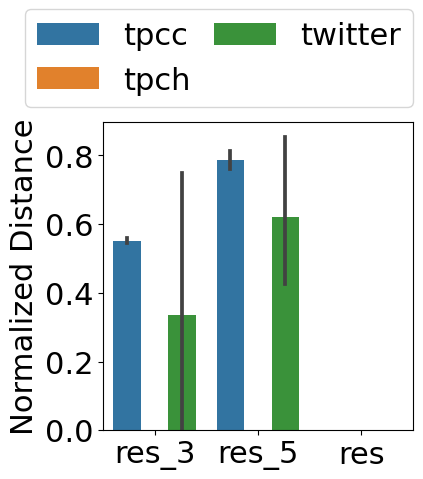

In [21]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Corr Norm', colwise=True, note='')

  run workload feature_group  distance
0   1     tpcc         res_3       NaN
1   1     tpcc         res_3       NaN
2   1     tpcc         res_3       NaN
3   7     tpcc         res_3       NaN
4   7     tpcc         res_3       NaN
5   7     tpcc         res_3       NaN
6   8     tpcc         res_3       NaN
7   8     tpcc         res_3       NaN
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.MTS Chi2 Norm


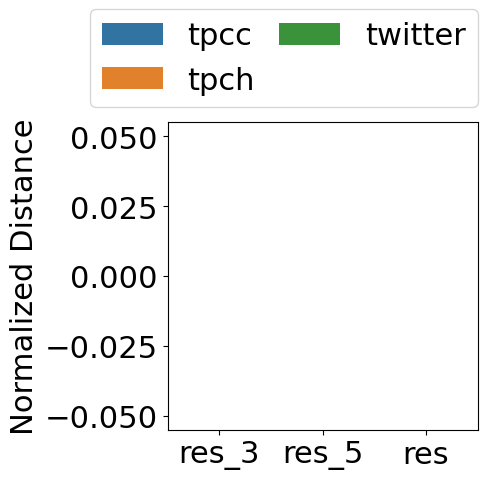

In [22]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Chi2 Norm', colwise=True, note='')

In [23]:
'''        
if colwise:
    simi_mtx = simi_calc.simi_col_mtx
else:
    simi_mtx = simi_calc.simi_mtx
'''
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)

    run workload feature_group  distance
97    3  twitter         res_3  0.000000
96    3  twitter         res_3  0.000000
86    8     tpcc         res_3  0.146211
84    8     tpcc         res_3  0.151342
85    8     tpcc         res_3  0.151537
100   4  twitter         res_3  0.153907
99    4  twitter         res_3  0.153907
98    4  twitter         res_3  0.153907
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram L21 Norm


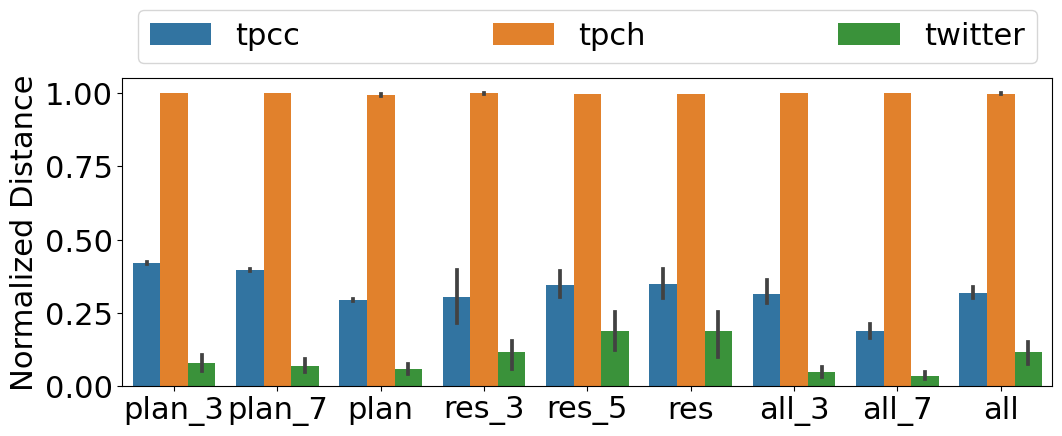

In [24]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram L21 Norm', colwise=True, note='')

    run workload feature_group  distance
97    3  twitter         res_3  0.000000
96    3  twitter         res_3  0.000000
86    8     tpcc         res_3  0.166119
84    8     tpcc         res_3  0.171947
85    8     tpcc         res_3  0.172169
100   4  twitter         res_3  0.174862
99    4  twitter         res_3  0.174862
98    4  twitter         res_3  0.174862
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram L11 Norm


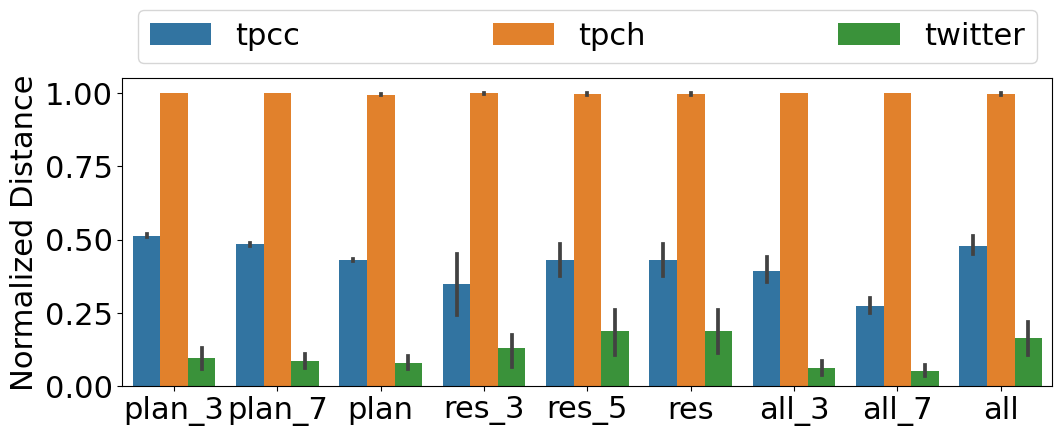

In [25]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram L11 Norm', colwise=True, note='')

    run workload feature_group  distance
97    3  twitter         res_3  0.000000
96    3  twitter         res_3  0.000000
86    8     tpcc         res_3  0.240443
84    8     tpcc         res_3  0.248879
85    8     tpcc         res_3  0.249201
100   4  twitter         res_3  0.253098
99    4  twitter         res_3  0.253098
98    4  twitter         res_3  0.253098
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Fro Norm


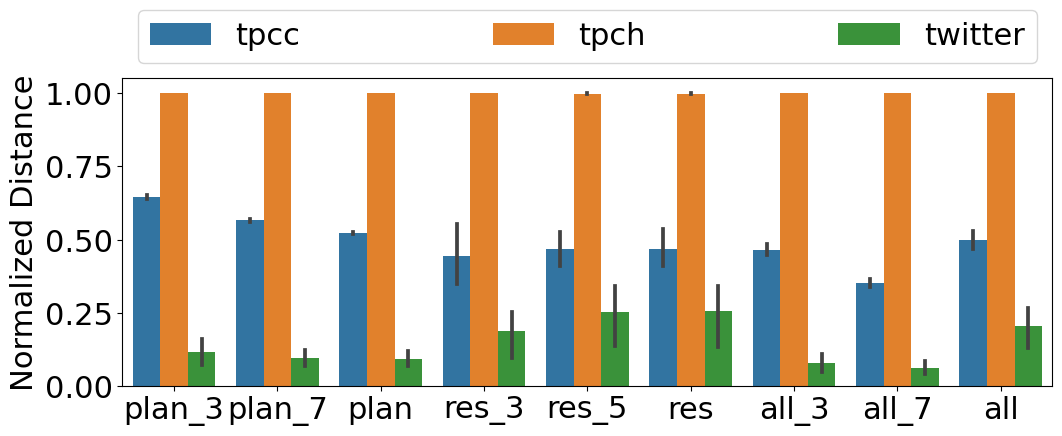

In [26]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Fro Norm', colwise=True, note='')

    run workload feature_group  distance
97    3  twitter         res_3  0.000000
96    3  twitter         res_3  0.000000
86    8     tpcc         res_3  0.056097
84    8     tpcc         res_3  0.059908
85    8     tpcc         res_3  0.061521
100   4  twitter         res_3  0.061906
99    4  twitter         res_3  0.061906
98    4  twitter         res_3  0.061906
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Canb Norm


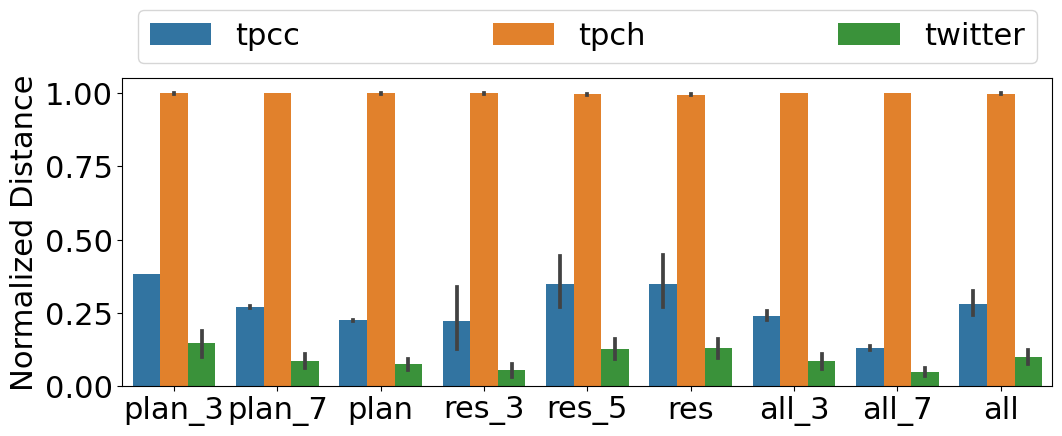

In [27]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Canb Norm', colwise=True, note='')

    run workload feature_group  distance
97    3  twitter         res_3  0.000000
96    3  twitter         res_3  0.000000
86    8     tpcc         res_3  0.054961
84    8     tpcc         res_3  0.060755
85    8     tpcc         res_3  0.060838
100   4  twitter         res_3  0.063845
99    4  twitter         res_3  0.063845
98    4  twitter         res_3  0.063845
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Chi2 Norm


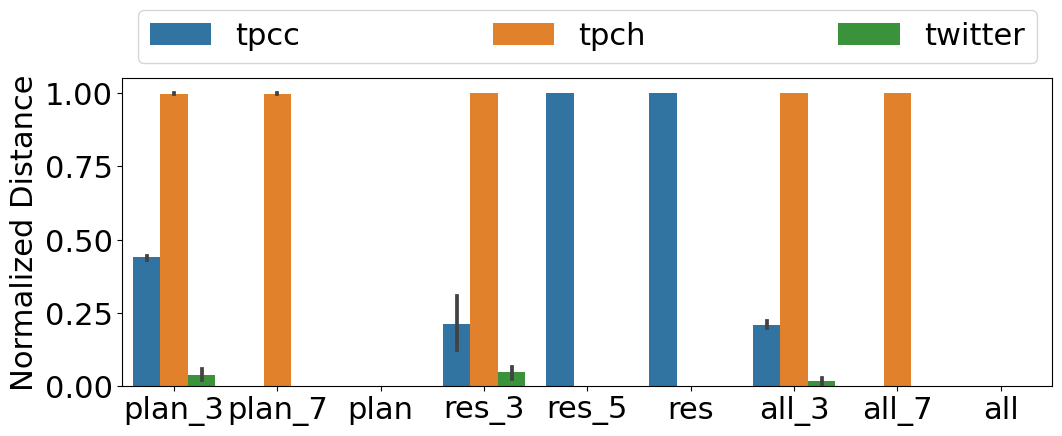

In [28]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Chi2 Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3       NaN
79   1     tpcc         res_3       NaN
80   1     tpcc         res_3       NaN
81   7     tpcc         res_3       NaN
82   7     tpcc         res_3       NaN
83   7     tpcc         res_3       NaN
84   8     tpcc         res_3       NaN
85   8     tpcc         res_3       NaN
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Corr Norm


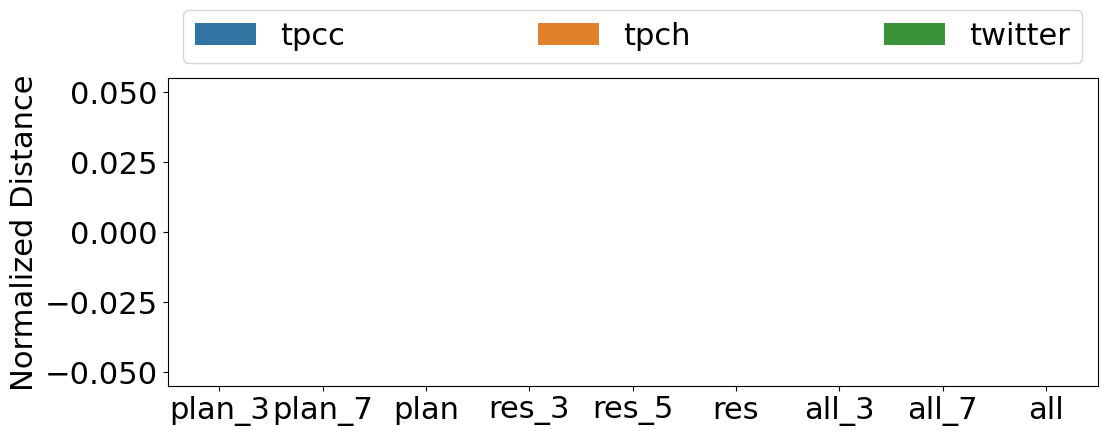

In [29]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Corr Norm', colwise=True, note='')

#### Phase Stats FP Distance Measure

    run workload feature_group  distance
103   9  twitter         res_3  0.900799
101   9  twitter         res_3  0.900799
100   4  twitter         res_3  0.900799
99    4  twitter         res_3  0.900799
98    4  twitter         res_3  0.900799
102   9  twitter         res_3  0.900799
96    3  twitter         res_3  0.900799
97    3  twitter         res_3  0.900799
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint L21 Norm


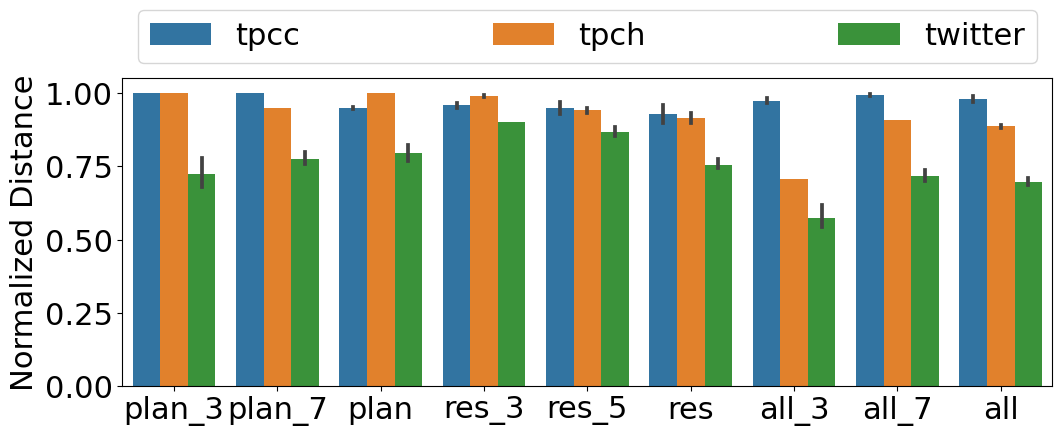

In [30]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint L21 Norm', colwise=True, note='')

    run workload feature_group  distance
103   9  twitter         res_3  0.828711
101   9  twitter         res_3  0.828711
98    4  twitter         res_3  0.828711
96    3  twitter         res_3  0.828711
102   9  twitter         res_3  0.828711
100   4  twitter         res_3  0.828711
99    4  twitter         res_3  0.828711
97    3  twitter         res_3  0.828711
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint L11 Norm


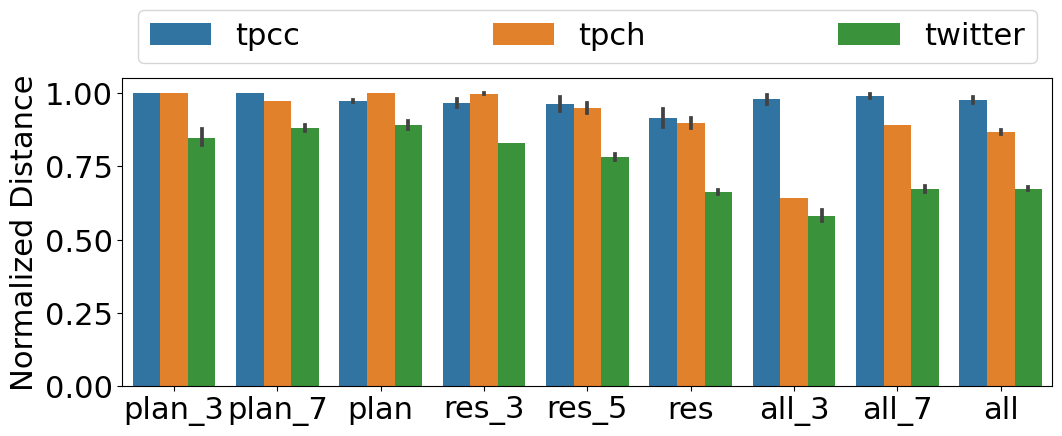

In [31]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint L11 Norm', colwise=True, note='')

    run workload feature_group  distance
83    7     tpcc         res_3  0.885274
82    7     tpcc         res_3  0.891531
85    8     tpcc         res_3  0.894360
103   9  twitter         res_3  0.895769
101   9  twitter         res_3  0.895769
100   4  twitter         res_3  0.895769
98    4  twitter         res_3  0.895769
102   9  twitter         res_3  0.895769
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Fro Norm


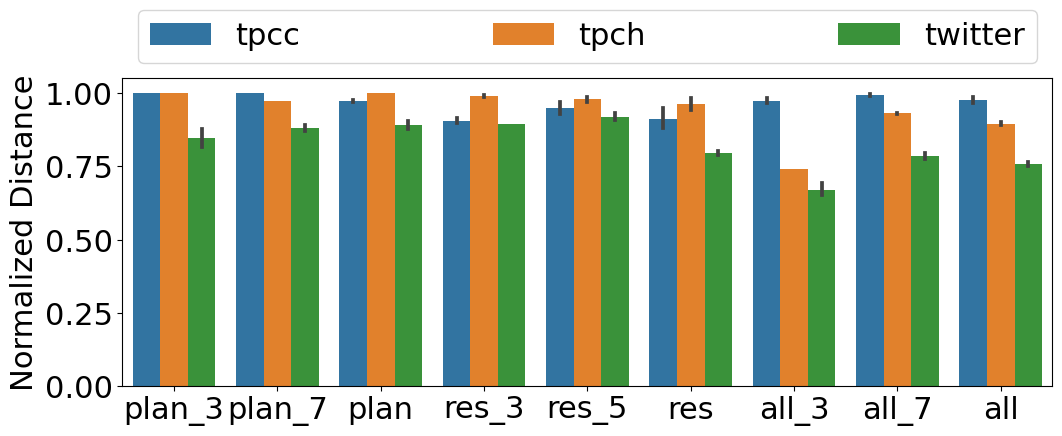

In [32]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Fro Norm', colwise=True, note='')

    run workload feature_group  distance
100   4  twitter         res_3  0.481524
98    4  twitter         res_3  0.481524
97    3  twitter         res_3  0.481524
96    3  twitter         res_3  0.481524
103   9  twitter         res_3  0.541714
101   9  twitter         res_3  0.541714
99    4  twitter         res_3  0.541714
102   9  twitter         res_3  0.541714
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Canb Norm


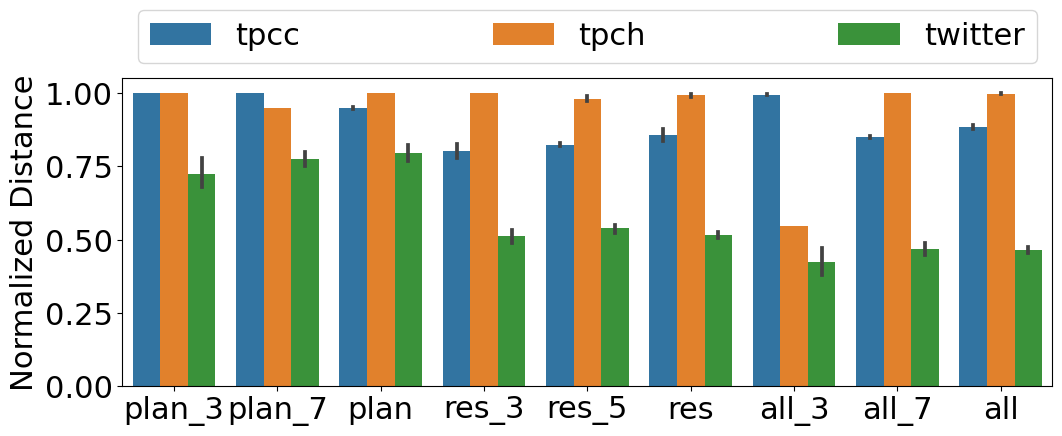

In [33]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Canb Norm', colwise=True, note='')

    run workload feature_group  distance
103   9  twitter         res_3  0.750694
101   9  twitter         res_3  0.750694
99    4  twitter         res_3  0.750694
102   9  twitter         res_3  0.750694
83    7     tpcc         res_3  0.850221
85    8     tpcc         res_3  0.853707
82    7     tpcc         res_3  0.854999
80    1     tpcc         res_3  0.862487
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Chi2 Norm


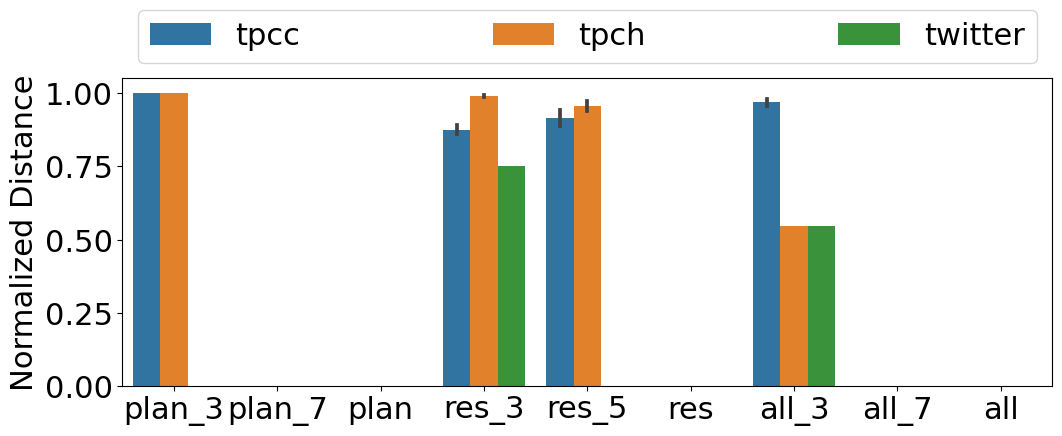

In [34]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Chi2 Norm', colwise=True, note='')

   run workload feature_group  distance
78   1     tpcc         res_3       NaN
79   1     tpcc         res_3       NaN
80   1     tpcc         res_3       NaN
81   7     tpcc         res_3       NaN
82   7     tpcc         res_3       NaN
83   7     tpcc         res_3       NaN
84   8     tpcc         res_3       NaN
85   8     tpcc         res_3       NaN
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Corr Norm


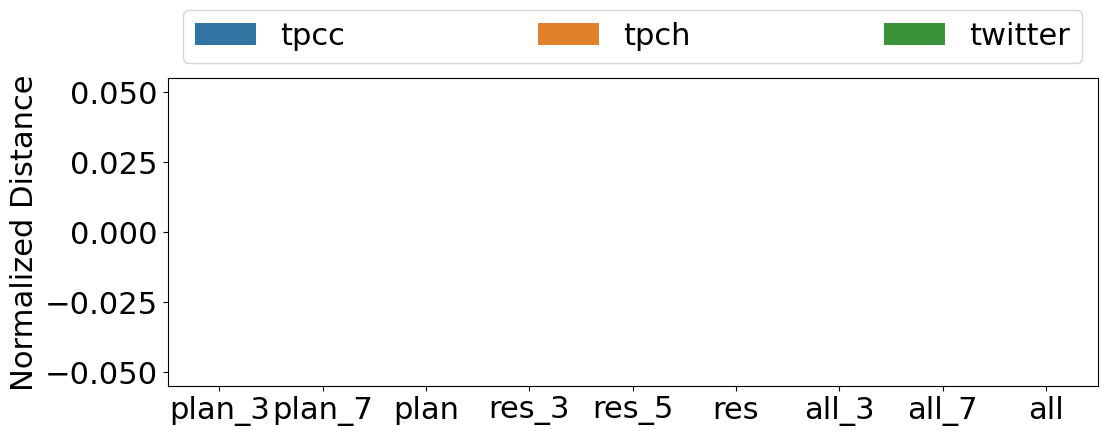

In [35]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, cpd='Kernel', penalty=15, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Corr Norm', colwise=True, note='')

#### Dependent DTW

   run workload feature_group  distance
18   3  twitter         res_3  0.001056
19   3  twitter         res_3  0.016602
8    8     tpcc         res_3  0.039628
6    8     tpcc         res_3  0.043059
7    8     tpcc         res_3  0.051476
21   4  twitter         res_3  0.065344
20   4  twitter         res_3  0.065586
22   4  twitter         res_3  0.065781
(26, 4)
Base Workload: twitter, Method: cpu16 Dependent.Dependent DTW


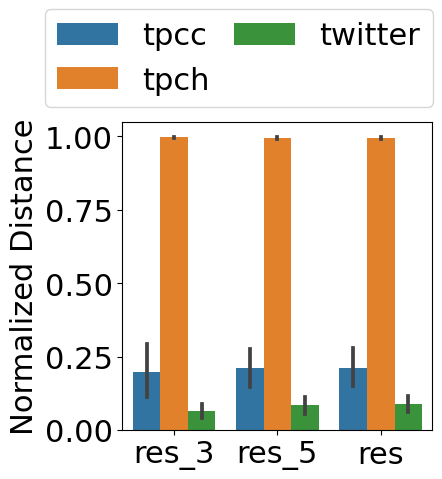

In [36]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Dependent DTW', colwise=False, note='')

#### Independent DTW

   run workload feature_group  distance
18   3  twitter         res_3  0.000726
19   3  twitter         res_3  0.011065
8    8     tpcc         res_3  0.031261
6    8     tpcc         res_3  0.033823
7    8     tpcc         res_3  0.038599
21   4  twitter         res_3  0.044467
20   4  twitter         res_3  0.044619
22   4  twitter         res_3  0.044768
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Independent DTW


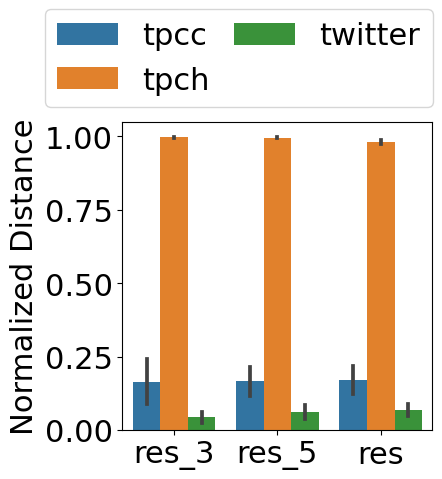

In [37]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Independent DTW', colwise=True, note='')

#### Dependent LCSS

   run workload feature_group  distance
25   9  twitter         res_3       0.0
23   9  twitter         res_3       0.0
22   4  twitter         res_3       0.0
3    7     tpcc         res_3       0.0
4    7     tpcc         res_3       0.0
5    7     tpcc         res_3       0.0
6    8     tpcc         res_3       0.0
7    8     tpcc         res_3       0.0
(26, 4)
Base Workload: twitter, Method: cpu16 Dependent.Dependent LCSS


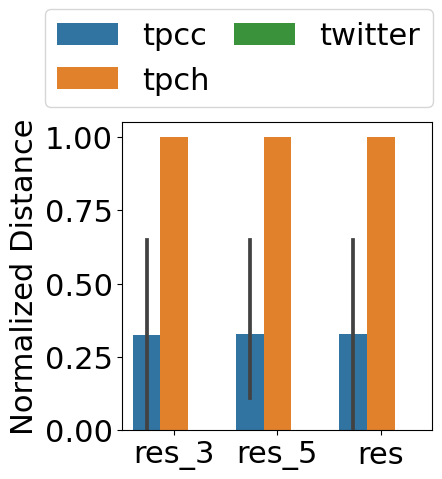

In [38]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Dependent LCSS', colwise=False, note='')

#### Independent LCSS

   run workload feature_group  distance
8    8     tpcc         res_3  0.000000
19   3  twitter         res_3  0.000000
18   3  twitter         res_3  0.000000
6    8     tpcc         res_3  0.011236
7    8     tpcc         res_3  0.095506
21   4  twitter         res_3  0.292135
20   4  twitter         res_3  0.303371
22   4  twitter         res_3  0.308989
(26, 4)
Base Workload: twitter, Method: cpu16 Independent.Independent LCSS


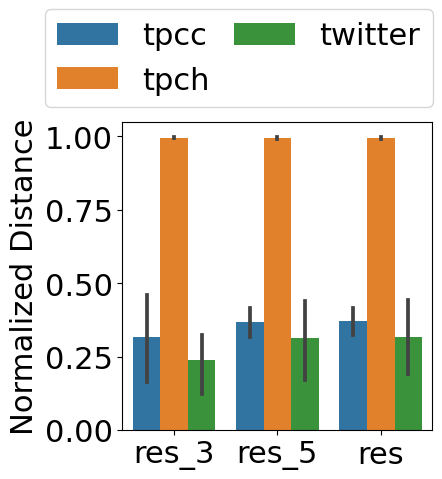

In [39]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Independent LCSS', colwise=True, note='')